In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  GradientBoostingClassifier
import xgboost as xgb

Проверочная выборка

In [15]:
pd.__version__ # нужно было понизить версию pandas

'1.5.3'

In [4]:
df = pd.read_table('C://Users//HP//Desktop//train.tsv', sep='\t')

In [5]:
df

,is_virus,filename,libs
0,1,VirusShare_44a578f74f71c566b2ea3702a581bf0d,kernel32.dll
1,1,VirusShare_852c5ccb274e5cac09cbaa0bf6ee9d76,"kernel32.dll,advapi32.dll,comctl32.dll,comdlg3..."
2,1,VirusShare_d7e9e47398dd04225d21fa3afc3acc5a,"msvcrt.dll,kernel32.dll,user32.dll,advapi32.dl..."
3,1,VirusShare_04dee410f3aef6ff2fbbf58cc6a38fbf,"kernel32.dll,user32.dll,gdi32.dll,advapi32.dll..."
4,1,VirusShare_04ce876f84647d16e6ef35a6deae629f,"kernel32.dll,advapi32.dll,msvcrt.dll,user32.dl..."
...,...,...,...
16285,1,VirusShare_0602df3a416a0fd1342f5e88fc6ecc46,"kernel32.dll,user32.dll,advapi32.dll,oleaut32...."
16286,0,bitsadmin.exe,"msvcrt.dll,api-ms-win-downlevel-kernel32-l1-1-..."
16287,1,2019-03-15T04_42_24+00_00_19739.exe,c:\\\\\\/\/\/\/\//\\\\\\\\\\\\\\//////\\/\/\/w...
16288,1,VirusShare_20ad408d92588f2871f5b2ffb0de819c,msvbvm60.dll


In [6]:
df = df.drop(["filename"], axis=1)
df_onehot = pd.concat([df.drop('libs', 1), df['libs'].str.get_dummies(sep=",")], 1)
df_onehot

C:\Users\HP\AppData\Local\Temp\ipykernel_3840\2524744396.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_onehot = pd.concat([df.drop('libs', 1), df['libs'].str.get_dummies(sep=",")], 1)
C:\Users\HP\AppData\Local\Temp\ipykernel_3840\2524744396.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_onehot = pd.concat([df.drop('libs', 1), df['libs'].str.get_dummies(sep=",")], 1)


,is_virus,.rsrc,.text1,3cxuicontrols.dll,3cxvoipphone.dll,ab.dll,abview.dll,acad.exe,acadaptersinfo.dll,acdb17.dll,...,xolehlp.dll,xpcom.dll,xpsservices.dll,xtp9601lib.dll,zlib.dll,zlib1.dll,zlibwapi.dll,zloadlibrarya,znzin.dll,zsikdy.dll
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16285,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16287,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16288,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_virus = df_onehot.loc[df_onehot['is_virus'] == 1].sum()
df_virus= df_virus[1:]
df_virus = pd.Series.to_frame(df_virus)
df_virus= df_virus.set_axis(['lib'], axis=1)
df_virus

,lib
.rsrc,1
.text1,1
3cxuicontrols.dll,0
3cxvoipphone.dll,0
ab.dll,0
...,...
zlib1.dll,2
zlibwapi.dll,0
zloadlibrarya,2
znzin.dll,1


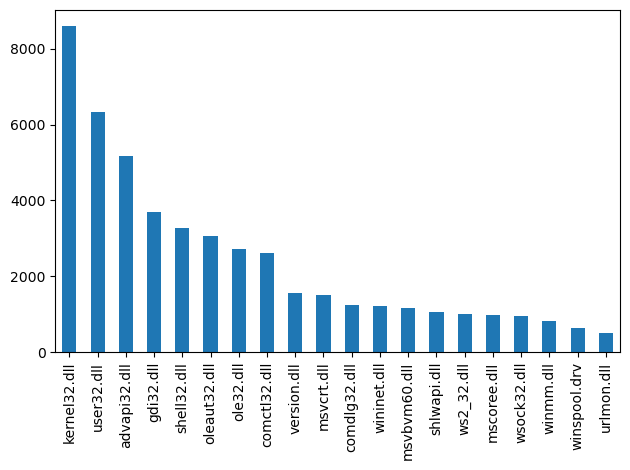

In [8]:
importances = pd.Series(df_virus["lib"], index=list(df_onehot.columns[1:]))
importances = importances.sort_values(ascending=False)
fig, ax = plt.subplots()
importances[:20].plot.bar( ax=ax)

fig.tight_layout()

In [9]:
df_clean = df_onehot.loc[df_onehot['is_virus'] == 0].sum()
df_clean= df_clean[1:]
df_clean = pd.Series.to_frame(df_clean)
df_clean= df_clean.set_axis(['lib'], axis=1)
df_clean


,lib
.rsrc,0
.text1,0
3cxuicontrols.dll,1
3cxvoipphone.dll,1
ab.dll,1
...,...
zlib1.dll,165
zlibwapi.dll,1
zloadlibrarya,0
znzin.dll,0


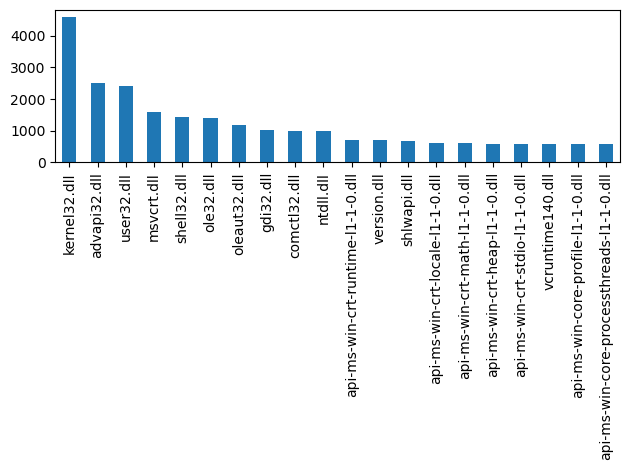

In [10]:
importances = pd.Series(df_clean["lib"], index=list(df_onehot.columns[1:]))
importances = importances.sort_values(ascending=False)
fig, ax = plt.subplots()
importances[:20].plot.bar( ax=ax)
fig.tight_layout()

In [11]:
x= df_onehot.drop(["is_virus"], axis = 1)
y = df_onehot["is_virus"]
x

,.rsrc,.text1,3cxuicontrols.dll,3cxvoipphone.dll,ab.dll,abview.dll,acad.exe,acadaptersinfo.dll,acdb17.dll,ace.dll,...,xolehlp.dll,xpcom.dll,xpsservices.dll,xtp9601lib.dll,zlib.dll,zlib1.dll,zlibwapi.dll,zloadlibrarya,znzin.dll,zsikdy.dll
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
